## Pacotes

In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import pickle
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
diretorio=os.getcwd()
diretorio

'/Users/igoracmorais/igor/4labs/consulting/score_credito/explicando_scorecard'

## Regressão Logistica

Modelo linear usado para classificacao (logit regression) onde usamos a funcao logistica para fazer essa modelagem. Ha basicamente dois tipos de modelos de classificacao: <br>
1. binario: com apenas duas classes para a variavel dependente;
2. multinomial: com três ou mais classes.

Para melhor entender como funciona o modelo de regressao logistica, veja a funcao sigmoid:

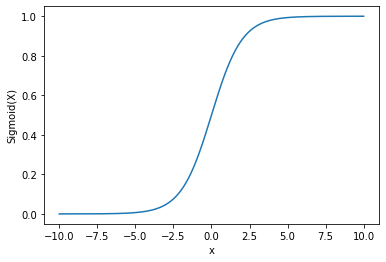

In [2]:
import math
x = np.linspace(-10, 10, 1000)
z = 1/(1 + np.exp(-x))
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
plt.show()

O nosso objetivo é encontrar a funcao de regressao logistica P(x) tal que as respostas previstas P(xi) sejam o mais proximas possiveis dos valores yi no intervalo 0-1. A. funcao que melhor pode descrever esse comportamento seria a sigmoid onde P(x) é a probabilidade de y=1 e 1-P(x) o inverso.

Um dos maiores problemas em machine learning é o overfitting - quando o modelo aprende muito com o banco de dados de treino, resultando em boa performance quando usamos o banco de dados de treino, mas muito ruim para dados de teste. A forma de reduzir esse risco seria via "regularizacao", onde, em regressao logistica, seria aplicando uma especie de "penalizacao" para coeficientes muito grandes (extremamente significativos). Alguns pacotes trazem isso pronto como o sckit-learn com 3 tipos de penalizacao:
1. L1 regularization: penaliza a funcao de maximizacao via soma dos valores absolutos dos coeficientes;
2. L2 regularization: penaliza a funcao de maximizacao via soma do quadrado dos pesos
3. elastic-net: combinacao linear entre L1 e L2.

#### Abrindo os dados e separando em treino e teste

In [3]:
from sklearn.model_selection import train_test_split

Abaixo abrimos o banco de dados com os respectivos woe criados para cada variavel. A seguir, separamos o mesmo entre y e x (independentes) e fazemos o split em treino e teste.

In [107]:
df=pd.read_csv('woe_to_model.csv',index_col=0)
y=df[['default']]
x=df.drop(['default'],axis=1)
xtreino, xteste, ytreino, yteste = train_test_split(x,y,test_size=0.20,
                                                        random_state=100,
                                                        stratify=y)
print(xtreino.shape,xteste.shape)
print(ytreino.shape,yteste.shape)

(800, 9) (200, 9)
(800, 1) (200, 1)


Uma parte importante nessa divisao é usar o termo "stratify". Esse permite que seja mantida a distribuição de valores de y tanto em treino quanto em teste. Por exemplo, o banco de dados total tem 70% dos valores de y=0.

In [5]:
df['default'].value_counts()

0    707
1    293
Name: default, dtype: int64

Aplicando o comando "stratify" preservamos essa distribuição no conjunto de dados de treino e teste, como podemos comprovar abaixo.

In [6]:
ytreino.value_counts()/ytreino.shape[0]

0    0.7075
1    0.2925
Name: default, dtype: float64

## 1. Modelo mais simples¶

In [7]:
from sklearn.linear_model import LogisticRegression

#### Passo 1. Definir o estimador¶

In [8]:
LR=LogisticRegression(penalty='l2',tol=0.0001, random_state=100,solver='sag')
LR

LogisticRegression(random_state=100, solver='sag')

#### Passo 2. treinar o modelo

In [9]:
LR.fit(xtreino,ytreino)
LR.classes_

array([0, 1])

#### Passo 3. Avaliar os resultados
Podemos ver, pelos atributos, diversas caracteristicas do nosso modelo. Umas das opções é o valor dos coeficientes.

In [10]:
LR.coef_

array([[ 0.83208145,  0.16817239,  0.04761475,  0.37602002,  0.84664707,
        -0.00916605,  0.63489167,  0.40230742,  0.98680199]])

In [11]:
LR.intercept_

array([-0.88414969])

#### Passo 4. Fazendo as previsoes
Agora podemos usar o modelo construído para prever os valores da variavel dependente usando o banco de dados de treino....

In [17]:
y_prev=LR.predict(xtreino)
y_prev[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#### Passo 5. Estima as probabilidades
E obter as probabilidades associadas a cada um dos valores....

In [15]:
y_prob=LR.predict_proba(xtreino)
y_prob

array([[0.70729763, 0.29270237],
       [0.57195564, 0.42804436],
       [0.73443212, 0.26556788],
       ...,
       [0.781986  , 0.218014  ],
       [0.74031045, 0.25968955],
       [0.68347819, 0.31652181]])

Note que o resultado apresentado tem duas colunas onde, na primeira, temos a probabilidade da variavel y=0 ou ainda P(y=0)=1-P(x) e, na segunda, P(y=1)=P(x). Veja que, como default, para valores onde P(x)>0.5 entao temos y=1. Portanto, toda vez que a primeira coluna tiver um resultado maior que a segunda coluna, o resultado da probabilidade será o valor da primeira classe.

#### Passo 6. avaliando o modelo
Há diversas formas de se avaliar o resultado de um modelo de ML de classificação. Vamos apresentar aqui algumas delas.

##### 6.1. Score
Sera que esse modelo é bom? Podemos ver esse resultado a partir do score: razao entre o numero de previsoes corretas sobre o total de observacoes...

In [18]:
LR.score(xtreino,ytreino)

0.70875

##### 6.2. Confusion Matrix
Essa matriz é uma das formas mais simples de se avaliar os resultados quando temos apenas 2 classes. Aqui podemos obter os resultados do Falso Positivo, Falso Negativo e True Positive e True Negative de forma direta. O sklearn fornece uma função que faz essa analise diretamente.

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytreino,y_prev)

array([[561,   5],
       [228,   6]])

mas isso pode ser melhor ilustrado em um grafico que ja vem pronto do sklearn.  Veja na função as diversas opções para melhorar cores, letras e etc.

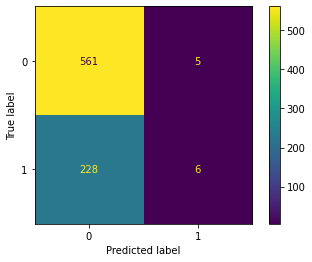

In [20]:
from sklearn.metrics import plot_confusion_matrix 
plot_confusion_matrix(LR, xtreino, ytreino); 

##### 6.3. Classification Report
Uma outra opção interessante seria um report com as estatísticas de accuracia para precision, recall e f1-score.

In [21]:
from sklearn.metrics import classification_report
print(classification_report(ytreino,y_prev))

              precision    recall  f1-score   support

           0       0.71      0.99      0.83       566
           1       0.55      0.03      0.05       234

    accuracy                           0.71       800
   macro avg       0.63      0.51      0.44       800
weighted avg       0.66      0.71      0.60       800



Precision: é uma medida da exatidao do classificador. É a razao dos verdadeiros positivos com a soma dos verdadeiros e falso positivo - para todas as observacoes positivas, qual percentual esta correto?

Recall: considera a habilidade do classificador em encontrar todos os valores positivos. É a razao dos valores positivos sobre a soma dos positivos+negativos. Para os valores positivos, qual percentual foi corretamente classificado?

f1 score: é uma media harmonica ponderada da estatistica de precision e recall, onde o melhor resultado é 1.0 e o pior 0.0 eee usamos para comparar diferentes modelos de classificacao.

support: numero de ocorrencias atuais na respectiva classe.

##### 6.4. ROC  - Receiver Operating Characteristic
É usado para ilustrar a métrica de seleção de modelos binarios ou multi-classificacao. ROC é a curva de probabilidade para as diferentes classes e revela o quao bom o modelo é para distinguir dentre as classes, considerando as probabilidades previstas. Uma ROC contem valores para FP-False positive no eixo horizontal e TP-True positive no eixo vertical. A area sob a curva é denominada de AUC -Area under Curve e, quanto maior for essa area, maior é o poder do modelo em distinguir as classes. O modelo ideal possui AUC=1.

ROC curve  usando o sklearn

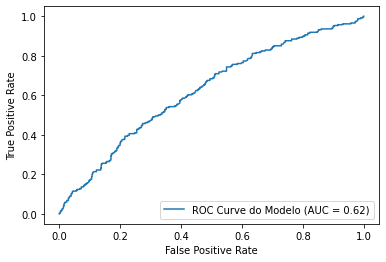

In [22]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(LR,xtreino,ytreino,name='ROC Curve do Modelo');

podemos melhorar visualmente essa curva inserindo uma linha reta...

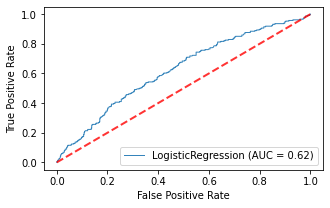

In [23]:
fig, ax = plt.subplots(figsize=(5,3))
plot_roc_curve(LR, xtreino, ytreino, alpha=0.9, lw=1, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8);

#### 6.5. Usando o pacote scorecardpy
O pacote que estima o scorecard no python traz uma função que pode ser usada para avaliar a performance do modelo:  perf_eva: permite usar diferentes estatísticas como KS-Kolmogorov-Smirnow, ROC, lift e curva de precision-recall. Abaixo reproduzimos a mesma: 

Parametros:
label= valores da variavel dependente (y) <br>
pred = probabilidade de previsão de y (ou o score) <br>
title = escolha um titulo para o grafico <br>
plot_type: tipo de grafico "ks", "lift", "roc", "pr". Default é ("ks","roc") <br>
show_plot = se mostra ou não o grafico. default é True <br>
positive = o valor da classe positiva, default "bad|1" <br>
seed = semente usada na estimativa. Default é 186. 

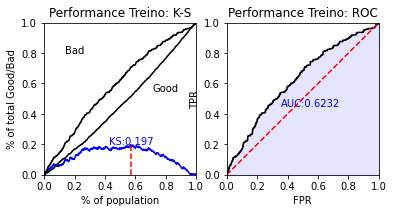

{'KS': 0.197,
 'AUC': 0.6232,
 'Gini': 0.2465,
 'pic': <Figure size 432x288 with 2 Axes>}

In [35]:
import scorecardpy as sc
perfLR=sc.perf_eva(label=ytreino,pred=y_prob[:,1],title='Performance Treino',
                  plot_type=("ks","roc"))
perfLR

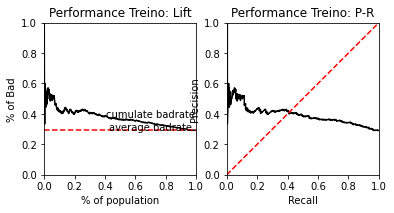

{'pic': <Figure size 432x288 with 2 Axes>}

In [36]:
perfLR2=sc.perf_eva(label=ytreino,pred=y_prob[:,1],title='Performance Treino',
                  plot_type=("lift","pr"))
perfLR2

Aqui encerramos a primeira parte de estimativa de um modelo simples de LR e respectiva avaliação. A seguir inserimos outros conceitos que podem ser uteis para melhorar nossa estimativa, como a cross-validation.

## 2. CV -  Cross Validation
Apesar da divisado do banco de dados entre treino e teste reduzir a possibilidade de termos um "overfiting", o fato é que ao testar diferentes parametros para um modelo, mantendo a mesma divisao do banco de dados entre treino e teste, estamos viezando a analise. A primeira forma de corrigir isso seria criando um banco de dados de validacao, mas com o prejuizo de ter que dividir os dados em tres grupos. A segunda alternativa seria aplicar a tecnica de cross-validation (CV).
O metodo CV consiste em dividir o banco de dados de treino em k grupos. Estimar um modelo para cada um dos k-1 grupos para encontrar o parametro ideal e somente depois usar o banco de dados de teste. Esse metodo é um dos possíveis que podemos aplicar para melhorar o processo de seleção de modelos em Machine Learning.

#### 2.1. metodo mais simples usando o cross_val_score¶
Esse é o método mais simples de se efazer uma analise do tipo cross-validation via sklearn. No exemplo abaixo, dividimos o banco de dados em cv diferentes formas. Estimamos o modelo LR para cada uma delas.  Pegamos o resultado final do score e armazenamos o mesmo em um array. Veja que essa divisao gerou um score (accuracy) minimo de 0.69 e um maximo de 0.73.

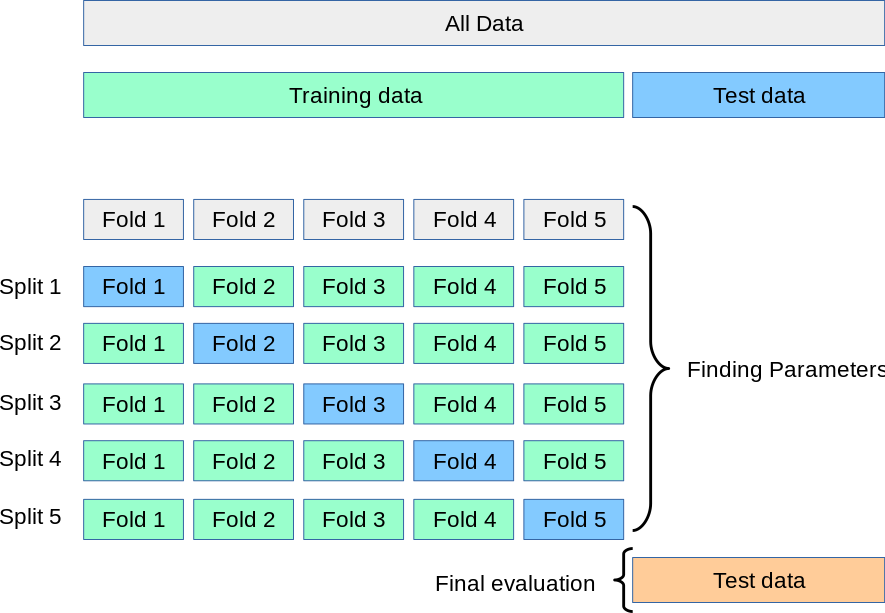

In [44]:
Image(filename='cv.png', width=500)

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
s1=time.time()
scores2=cross_val_score(estimator=LR, X=xtreino, y=ytreino, cv=8, scoring='accuracy')
s2=time.time()
print("tempo decorrido: ",s2-s1)
print('media dos scores = ',scores2.mean())

tempo decorrido:  0.08037519454956055
media dos scores =  0.7074999999999999


Aqui fizemos um split do banco de dados de treino cv vezes. Em cada uma delas, geramos um modelo do tipo LR, mas com uma amostra diferente.

In [52]:
print("accuracy:  ", scores2)

accuracy:   [0.69 0.7  0.73 0.73 0.71 0.7  0.71 0.69]


##### 2.2. Usando diferentes metricas com cross_validate
Essa opcao se difere da anterior pois agora podemos inserir mais de uma metrica para avaliacao e retorna, como resultado: <br> 
1. fit_time; 
2. score_time; 
3. test_score.

In [53]:
from sklearn.model_selection import cross_validate
s1=time.time()
scores3=cross_validate(estimator=LR, X=xtreino, y=ytreino, 
                       cv=8, scoring='average_precision')
s2=time.time()
print("tempo decorrido: ",s2-s1)
print('scores reportados = ',scores3.keys())

tempo decorrido:  0.08404707908630371
scores reportados =  dict_keys(['fit_time', 'score_time', 'test_score'])


In [54]:
print('tempo usando banco de dados de treino:\n',scores3['fit_time'])

tempo usando banco de dados de treino:
 [0.00764489 0.00662279 0.00716496 0.0065248  0.00594425 0.00651288
 0.00687695 0.00811195]


In [56]:
print('score do teste para cada um dos CV para "average precision":\n',scores3['test_score'])

score do teste para cada um dos CV para "average precision":
 [0.34359344 0.39097955 0.39491811 0.44815434 0.43888092 0.34781417
 0.50325312 0.30805666]


podemos inserir diferentes metricas para comparação usando o cross_Validate:

In [57]:
from sklearn.metrics import accuracy_score, recall_score
metricas=['precision_macro','recall_macro','recall']
s1=time.time()
scores4=cross_validate(LR, xtreino, ytreino, cv=8,scoring=metricas)
s2=time.time()
print("tempo decorrido: ",s2-s1)
print('scores reportados =\n',scores4.keys())

tempo decorrido:  0.09979581832885742
scores reportados =
 dict_keys(['fit_time', 'score_time', 'test_precision_macro', 'test_recall_macro', 'test_recall'])


Veja que é colocado o nome "test_" antes do nome de cada um dos scores.
Agora, podemos ver os resultados para um score especifico usando:

In [58]:
scores4['test_recall']

array([0.        , 0.03448276, 0.06896552, 0.06896552, 0.        ,
       0.        , 0.03333333, 0.        ])

veja a lista de metricas aqui: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

##### 2.3. Usando um processo iterativo - KFold
O metodo KFold divide a amostra em k diferentes grupos, chamados de "folds" de tamanho igual. A funcao de previsao é treinada para cada um desses grupos e o k-1 fold é usado para teste. Veja que a classe ou o grupo não influenciam a divisao pelo kfold que gera dois bancos de dados em cada uma dos cv: i) um conjunto de treino; ii) dados de teste.

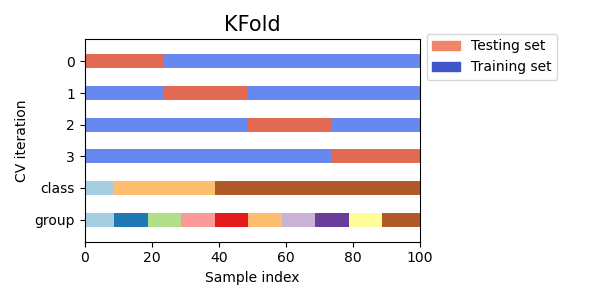

In [59]:
Image(filename='kfold.png', width=500)

A seguir mostramos um exemplo de como dividir um banco de dados em treino e teste usando o kfold. Aqui criamos 4 conjuntos de treino e teste para x e y.

In [60]:
from sklearn.model_selection import KFold
dados = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8])
kfold =KFold(n_splits=4,shuffle=False,random_state=1)
for train, test in kfold.split(dados):
    print('train: %s, test: %s' % (dados[train], dados[test]))

train: [0.3 0.4 0.5 0.6 0.7 0.8], test: [0.1 0.2]
train: [0.1 0.2 0.5 0.6 0.7 0.8], test: [0.3 0.4]
train: [0.1 0.2 0.3 0.4 0.7 0.8], test: [0.5 0.6]
train: [0.1 0.2 0.3 0.4 0.5 0.6], test: [0.7 0.8]


##### 2.4. KFold repetido
Aqui apenas repetimos o processo do KFold quantas vezes quisermos.

In [75]:
from sklearn.model_selection import RepeatedKFold
rkfold =RepeatedKFold(n_splits=4,random_state=1,n_repeats=2)
for train1, test1 in rkfold.split(dados):
    print('train: %s, test: %s' % (dados[train1], dados[test1]))

train: [0.1 0.2 0.4 0.5 0.6 0.7], test: [0.3 0.8]
train: [0.1 0.3 0.4 0.5 0.6 0.8], test: [0.2 0.7]
train: [0.2 0.3 0.4 0.6 0.7 0.8], test: [0.1 0.5]
train: [0.1 0.2 0.3 0.5 0.7 0.8], test: [0.4 0.6]
train: [0.1 0.2 0.5 0.6 0.7 0.8], test: [0.3 0.4]
train: [0.1 0.2 0.3 0.4 0.6 0.7], test: [0.5 0.8]
train: [0.1 0.3 0.4 0.5 0.6 0.8], test: [0.2 0.7]
train: [0.2 0.3 0.4 0.5 0.7 0.8], test: [0.1 0.6]


##### 2.5. Leave one out (LOO)
Esse método é bem simples. Aqui dividimos o banco de dados de tal forma a ter apenas um para teste e todos os demais para treino. Assim, se temos um df com n=8 dados, teremos n=8 conjuntos de dados de treino e n=8 dados de teste. Esse metodo permite que o modelo seja treinado com o maior numero de dados possivel.

In [76]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
for train, test in loo.split(dados):
    print("%s %s" % (train, test))

[1 2 3 4 5 6 7] [0]
[0 2 3 4 5 6 7] [1]
[0 1 3 4 5 6 7] [2]
[0 1 2 4 5 6 7] [3]
[0 1 2 3 5 6 7] [4]
[0 1 2 3 4 6 7] [5]
[0 1 2 3 4 5 7] [6]
[0 1 2 3 4 5 6] [7]


##### 2.6. Leave P Out (LPO)
Aqui temos um procedimento similar ao anterior mas com a liberdade de escolher p dados para ficarem de fora dos dados de treino. Veja que o resultado é uma combinação (n,p) de pares treino-teste.

In [77]:
from sklearn.model_selection import LeavePOut
lpo = LeavePOut(p=2)
for train, test in lpo.split(dados):
    print("%s %s" % (train, test))

[2 3 4 5 6 7] [0 1]
[1 3 4 5 6 7] [0 2]
[1 2 4 5 6 7] [0 3]
[1 2 3 5 6 7] [0 4]
[1 2 3 4 6 7] [0 5]
[1 2 3 4 5 7] [0 6]
[1 2 3 4 5 6] [0 7]
[0 3 4 5 6 7] [1 2]
[0 2 4 5 6 7] [1 3]
[0 2 3 5 6 7] [1 4]
[0 2 3 4 6 7] [1 5]
[0 2 3 4 5 7] [1 6]
[0 2 3 4 5 6] [1 7]
[0 1 4 5 6 7] [2 3]
[0 1 3 5 6 7] [2 4]
[0 1 3 4 6 7] [2 5]
[0 1 3 4 5 7] [2 6]
[0 1 3 4 5 6] [2 7]
[0 1 2 5 6 7] [3 4]
[0 1 2 4 6 7] [3 5]
[0 1 2 4 5 7] [3 6]
[0 1 2 4 5 6] [3 7]
[0 1 2 3 6 7] [4 5]
[0 1 2 3 5 7] [4 6]
[0 1 2 3 5 6] [4 7]
[0 1 2 3 4 7] [5 6]
[0 1 2 3 4 6] [5 7]
[0 1 2 3 4 5] [6 7]


##### 2.7. Shuffle and Split
Esse processo é melhor que o kfold pois permite que sejam controlado tanto o numero de iterações quanto a proporção da amostra que vai em cada uma das divisões de treino e teste.

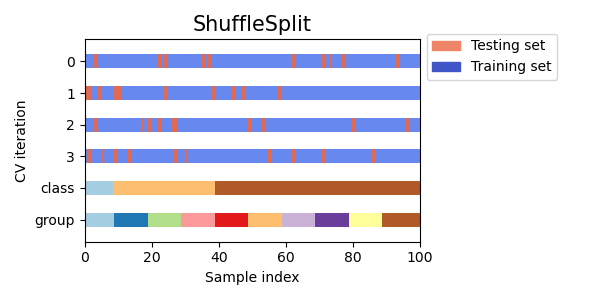

In [78]:
Image(filename='shuffle_split.png', width=500)

In [79]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
for train_index, test_index in ss.split(dados):
    print("%s %s" % (train_index, test_index))

[1 7 3 0 5 4] [6 2]
[3 7 0 4 2 5] [1 6]
[3 4 7 0 6 1] [5 2]
[6 7 3 4 1 0] [2 5]
[1 6 3 2 0 7] [4 5]


O grupo de cross_validation apresentado a seguir é útil quando temos um conjunto de dados que possui uma distribuição considerada como "imbalance". Os metodos conhecidos como "stratified" permitem garantir que a frequencia das classes seja preservada no conjunto de dados de treino e teste.

#### 2.8. Usando o StratifiedKFold
Esse metodo, uma variacao do kfold, procura fazer a divisao dos dados de tal forma a preservar a distribuicao da amostra para cada uma das caracteristicas do target.

In [84]:
from sklearn.model_selection import StratifiedKFold
X1 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8])
y1 = np.array(['F', 'V', 'V', 'F', 'F', 'V','V','F'])
Skfold =StratifiedKFold(4,shuffle=False,random_state=1)
for treino, teste in Skfold.split(X1,y1):
    print('Xtreino: %s, Xteste: %s' % (X1[treino], X1[teste]))
    print('ytreino: %s, yteste: %s' % (y1[treino], y1[teste]))

Xtreino: [0.3 0.4 0.5 0.6 0.7 0.8], Xteste: [0.1 0.2]
ytreino: ['V' 'F' 'F' 'V' 'V' 'F'], yteste: ['F' 'V']
Xtreino: [0.1 0.2 0.5 0.6 0.7 0.8], Xteste: [0.3 0.4]
ytreino: ['F' 'V' 'F' 'V' 'V' 'F'], yteste: ['V' 'F']
Xtreino: [0.1 0.2 0.3 0.4 0.7 0.8], Xteste: [0.5 0.6]
ytreino: ['F' 'V' 'V' 'F' 'V' 'F'], yteste: ['F' 'V']
Xtreino: [0.1 0.2 0.3 0.4 0.5 0.6], Xteste: [0.7 0.8]
ytreino: ['F' 'V' 'V' 'F' 'F' 'V'], yteste: ['V' 'F']


veja, no exemplo abaixo, como que o percentual de valores y se mantem igual para cada uma das divisoes que fizemos no Skfold.

In [118]:
skfold1=1
for index_treino, index_teste in Skfold.split(df,target):
    treino=df.loc[index_treino,:]
    teste=df.loc[index_teste,:]
    print('Fold',str(skfold1), " % da classe: ", 
          sum(teste['default'])/len(teste['default']))
    skfold1+=1

Fold 1  % da classe:  0.296
Fold 2  % da classe:  0.292
Fold 3  % da classe:  0.292
Fold 4  % da classe:  0.292


#### 2.9. StratifiedKFold Repetido
Tambem podemos usar um metodo que repete o procedimento do StratifiedKFold quantas vezes quisermos.

In [124]:
from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=4, n_repeats=2,random_state=100)
for treino, teste in rskf.split(X1,y1):
    print('Xtreino: %s, Xteste: %s' % (X1[treino], X1[teste]))
    print('ytreino: %s, yteste: %s' % (y1[treino], y1[teste]))

Xtreino: [0.1 0.2 0.3 0.4 0.5 0.7], Xteste: [0.6 0.8]
ytreino: ['F' 'V' 'V' 'F' 'F' 'V'], yteste: ['V' 'F']
Xtreino: [0.1 0.3 0.5 0.6 0.7 0.8], Xteste: [0.2 0.4]
ytreino: ['F' 'V' 'F' 'V' 'V' 'F'], yteste: ['V' 'F']
Xtreino: [0.2 0.4 0.5 0.6 0.7 0.8], Xteste: [0.1 0.3]
ytreino: ['V' 'F' 'F' 'V' 'V' 'F'], yteste: ['F' 'V']
Xtreino: [0.1 0.2 0.3 0.4 0.6 0.8], Xteste: [0.5 0.7]
ytreino: ['F' 'V' 'V' 'F' 'V' 'F'], yteste: ['F' 'V']
Xtreino: [0.1 0.2 0.4 0.6 0.7 0.8], Xteste: [0.3 0.5]
ytreino: ['F' 'V' 'F' 'V' 'V' 'F'], yteste: ['V' 'F']
Xtreino: [0.2 0.3 0.4 0.5 0.6 0.8], Xteste: [0.1 0.7]
ytreino: ['V' 'V' 'F' 'F' 'V' 'F'], yteste: ['F' 'V']
Xtreino: [0.1 0.2 0.3 0.4 0.5 0.7], Xteste: [0.6 0.8]
ytreino: ['F' 'V' 'V' 'F' 'F' 'V'], yteste: ['V' 'F']
Xtreino: [0.1 0.3 0.5 0.6 0.7 0.8], Xteste: [0.2 0.4]
ytreino: ['F' 'V' 'F' 'V' 'V' 'F'], yteste: ['V' 'F']


#### 2.10. Fazendo previsão com CrossValidation
Podemos usar o cv para fazer uma previsão diretamente com o estimador escolhido. Nesse caso, o sklearn oferece a opção do "cross_val_predict".

In [126]:
from sklearn.model_selection import cross_val_predict
y_previsto=cross_val_predict(estimator=LR,X=xtreino, y=ytreino, 
                             cv=8,method='predict')

### 3. Modelo de Regressão Logística com Cross Validation
existe uma classe de estimadores que contem o cross validation no processo de estimativa, equivalente ao uso do GridSearchCV. Nesse caso, os estimadores que possuem essa opção tem nome dado por "estimadorCV". Abaixo mostramos como usar o LogisticRegressionCV. Outros exemplos são: i) RidgeClassifierCV; ii) RidgeCV; iii) ElasticNetCV; iv) LarsCV; v) LassoLarsCV.

In [131]:
from sklearn.linear_model import LogisticRegressionCV
LR_=LogisticRegressionCV(Cs=2, fit_intercept=True, cv=8, penalty='l2', scoring='accuracy', 
                         solver='lbfgs', tol=0.0001, max_iter=100, verbose=0, refit=True,
                         random_state=123)
LR_.fit(xtreino,ytreino)
LR_.coef_

array([[ 0.92535946,  0.55988883,  2.36657401,  0.87069863,  0.94691441,
        -0.00615128,  0.83676581,  3.4147888 ,  1.15478223]])

o resultado de cada score para o cv pode ser visto em:

In [132]:
LR_.scores_

{1: array([[0.71, 0.71],
        [0.71, 0.71],
        [0.71, 0.73],
        [0.71, 0.73],
        [0.71, 0.71],
        [0.71, 0.71],
        [0.7 , 0.71],
        [0.7 , 0.69]])}

ou ainda podemos obter o score do melhor modelo usando:

In [133]:
LR_.score(xtreino,ytreino)

0.7075

e a confusion matrix pode ser obtida usando:

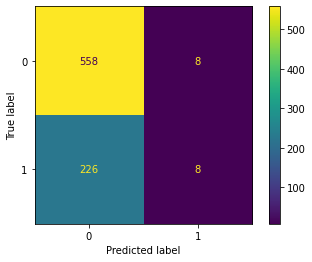

In [134]:
plot_confusion_matrix(LR_, xtreino, ytreino); 

### 4. Modelo de Regressão Logistica com SGD - Stochastic Gradient Descent
Uma outra opção de usar modelos de regressão logistica seria a partir do processo de aprendizado conhecido como SGD, onde a função perda é estimada em cada amostra no tempo e o modelo é atualizado de forma descendente. O SGD é um método simples e eficiente (é uma técnica de otimização) usada para treinar modelos e estimar classificadores e regressores lineares que usam uma função convexa (função perda) e é bem útil quando temos bancos de dados extensos, bem como na presença de matrizes esparsas (classificação de texto em NLP). Sempre que for usar esse otimizador, faça primeiro a normalização dos dados, pois esse estimador é sensível a escala dos dados.

##### 4.1. O modelo SGDClassifier
A aplicação feita a seguir considera o SGDClassifier mas também fazendo uso de um recurso que veremos em detalhe mais a frente: o GridSearchCV. Aqui definimos os parametros de busca (otimização de hyperparametros), também conhecido como "espaço" e aplicamos no SGD. O resultado final seria o modelo com os melhores hyperparametros.

In [146]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection  import GridSearchCV
parametros_SGDC={'alpha':[0.0001,0.0005,0.001],
                'penalty':('l1','l2','elasticnet'),
                'loss':('log','modified_huber','hinge','perceptron')}
logistic = SGDClassifier(class_weight = 'balanced', random_state=28,
                         n_jobs=-1,fit_intercept=False)
clf_logistic=GridSearchCV(logistic,parametros_SGDC)
clf_logistic.fit(xtreino, ytreino)
clf_logistic.score(xtreino,ytreino)

0.7075

o nosso melhor modelo é no formato mostrado abaixo, com o classificador perceptron:

In [147]:
clf_logistic.best_params_

{'alpha': 0.001, 'loss': 'perceptron', 'penalty': 'l1'}

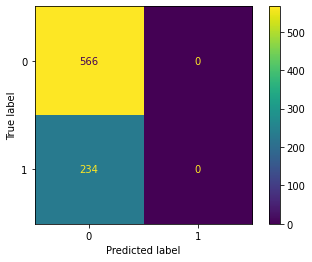

In [148]:
plot_confusion_matrix(clf_logistic, xtreino, ytreino); 

o SGC aplicado a um problema de classificação possui estimativas ruins para as probabilidades. Há tecnicas uteis para corrigir isso e que mostraremos na sessão seguinte. Mas, antes, comparamos a taxa de erro de diferentes estimadores de acordo com o tamanho amostral.

##### 4.2. Comparando diferentes solvers
Esse exemplo está no link abaixo e reproduzimos aqui para o banco de dados usado nesse exemplo.
https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_comparison.html#sphx-glr-auto-examples-linear-model-plot-sgd-comparison-py


treinando SGD
treinando ASGD
treinando Perceptron
treinando Passive-Aggressive I
treinando Passive-Aggressive II
treinando SAG


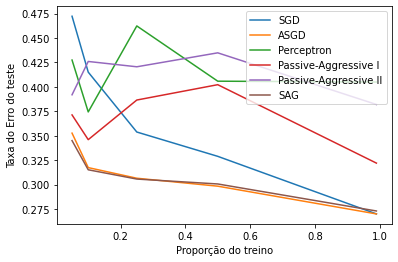

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
heldout = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20
estimadores = [
    ("SGD", SGDClassifier(max_iter=100)),
    ("ASGD", SGDClassifier(average=True)),
    ("Perceptron", Perceptron()),
    ("Passive-Aggressive I", PassiveAggressiveClassifier(loss='hinge',
                                                         C=1.0, tol=1e-4)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(loss='squared_hinge',
                                                          C=1.0, tol=1e-4)),
    ("SAG", LogisticRegression(solver='sag', tol=1e-1, C=1.e4 / x.shape[0]))
]

xx = 1. - np.array(heldout)
for nome, clf in estimadores:
    print("treinando %s" % nome)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        yy_ = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = \
                train_test_split(x.values, y.values, test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            yy_.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(yy_))
    plt.plot(xx, yy, label=nome)

plt.legend(loc="upper right")
plt.xlabel("Proporção do treino")
plt.ylabel("Taxa do Erro do teste")
plt.show()

### 5. CalibratedClassifierCV
Muitas vezes resolvemos um problema de classificação e o estimador não produz bons resultados para a previsão de probabilidade, e isso é importante na hora de determinar a classe a partir da probabilidade. Esse problema ocorre quando usamos o SGD, por exemplo, que não fornece a previsão de probabilidade. Em algumas aplicações queremos ter mais precisão da probabilidade, em outras, nem tanto. <br>
Podemos usar esse metodo de duas formas: i) fazendo uma estimativa inicial e depois usando o melhor estimador para calibrar as probabilidades; ii) aplicar o estimador diretamente no calibrador. Abaixo usamos a primeira opção, aplicando o calibrador ao melhor estimador encontrado.

In [155]:
# apos estimar o melhor modelo, calibramos para as probabilidades
from sklearn.calibration import CalibratedClassifierCV
sig_clf_logistic = CalibratedClassifierCV(base_estimator=clf_logistic.best_estimator_, 
                                          method='sigmoid',cv='prefit')
sig_clf_logistic.fit(xtreino, ytreino)
sig_clf_logistic.score(xtreino,ytreino)

0.7075

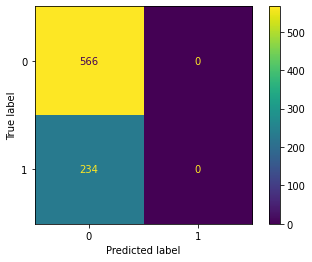

In [156]:
plot_confusion_matrix(sig_clf_logistic, xtreino, ytreino); 

##### 5.1. Comparando curvas de probabilidade calibradas
Adaptamos o exemplo do link abaixo para os dados desse notebook para comparar o resultado do calibrador de probabilidades em diferentes estimadores de classificação usando tanto a calibração isotonica quanto a sigmoid. A metrica de comparação é a "Brier Score" onde quanto menor o valor, melhor. No geral os calibradores apresentam um resultado semelhante. No segundo grupo de graficos usamos o calibrador para medir a eficiencia em classificadores SVM (LinearSVC) e os resultados também são similares. <br>
https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py

In [157]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split

In [163]:
def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1.)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(xtreino, ytreino)
        y_pred = clf.predict(xteste)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(xteste)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(xteste)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(yteste, prob_pos,  pos_label=1)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(yteste, y_pred))
        print("\tRecall: %1.3f" % recall_score(yteste, y_pred))
        print("\tF1: %1.3f\n" % f1_score(yteste, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(yteste, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

Logistic:
	Brier: 0.204
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

Naive Bayes:
	Brier: 0.218
	Precision: 0.333
	Recall: 0.119
	F1: 0.175

Naive Bayes + Isotonic:
	Brier: 0.208
	Precision: 0.500
	Recall: 0.017
	F1: 0.033

Naive Bayes + Sigmoid:
	Brier: 0.206
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

Logistic:
	Brier: 0.204
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

SVC:
	Brier: 0.295
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

SVC + Isotonic:
	Brier: 0.205
	Precision: 0.000
	Recall: 0.000
	F1: 0.000

SVC + Sigmoid:
	Brier: 0.204
	Precision: 0.000
	Recall: 0.000
	F1: 0.000



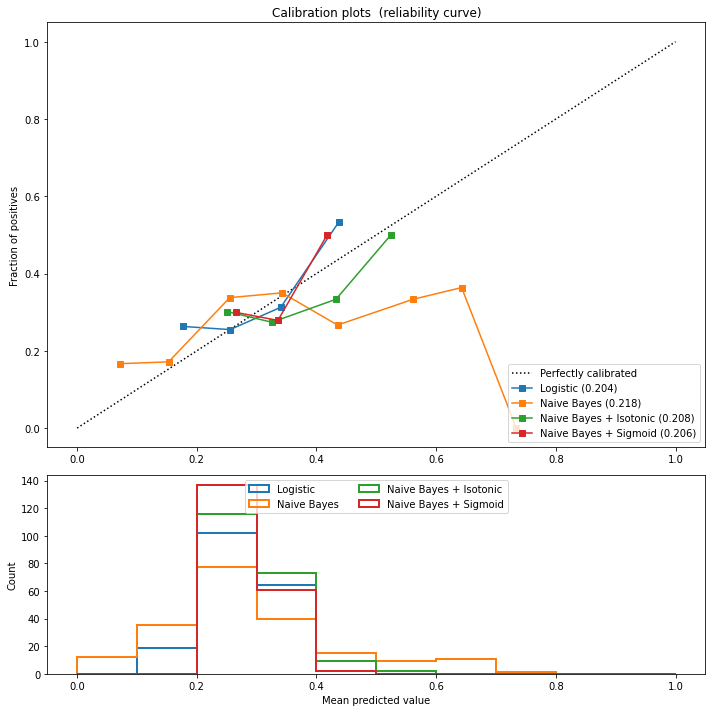

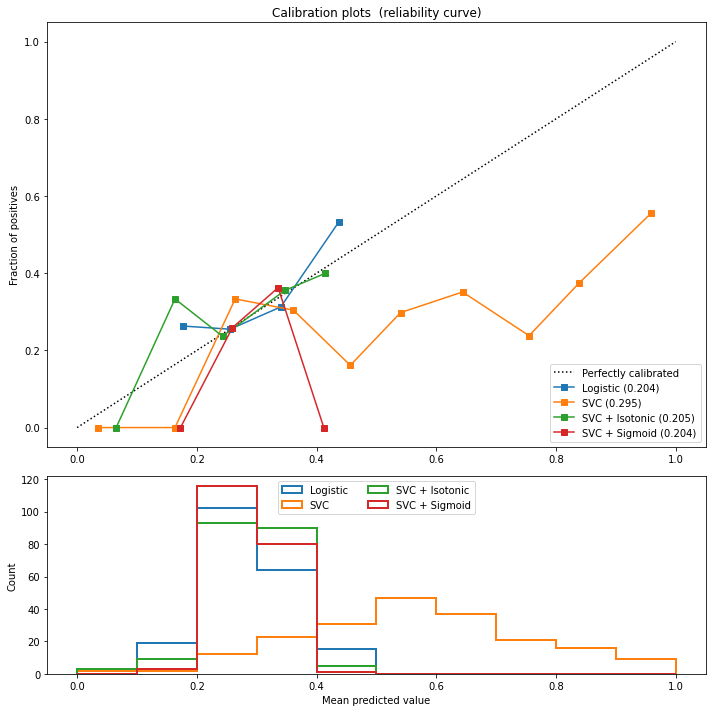

In [164]:
# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(max_iter=10000), "SVC", 2)

plt.show()

### 6. Otimização de Hyperparâmetros
A escolha do melhor modelo a ser usado se encaixa no que se deefine como "Model Selection" e o scikit-learn tem uma sessão especial sobre o tema. Nesse processo podemos usar diferentes técnicas que são agrupadas em: i) cross-validation: qual metodo de split dos dados usar para treinar os modelos; ii) otimização de hyperparametros, onde procuramos encontrar qual a melhor combinação em um modelo; iii) validação: usa-se desde metodos do tipo cross-validation até curva de aprendizado (learning curve) e curva de validação (validation curve). Já vimos anteriormente as aplicações com CV. Agora vamos investigar como seria o processo de otimização de hyperparametros. <br>
Os modelos e estimadores que usamos em ML e AI possuem diversos hyperparametros (imputados manualmente) e valores diferentes desses podem mudar de forma significativa o resultado final. O scikit-learn oferece uma boa biblioteca para testar diferentes valores dos hyparametros e encontrar o resultado otimo. O primeiro passo para fazer isso seria definir o espaço de busca dos hyperparametros e podemos usar basicamente dois metodos para fazer esse processo de otimizacao:
1. Random Search: busca os valores de hyperparametros de forma aleatoria. Descobre valores e consome mais tempo computacional. API: RandomizedSearchCV
2. Grid Search: constroi uma grade de valores e faz a busca dentro desse intervalo. Bom para testar combinações de valores ja conhecidas. Convergencia mais rapida. API: GridSearchCV.  <br>

Em ambos os processos temos que especificar o modelo e o espaco de busca (quais hyperparametros testar). O scikit-learn disponibiliza outros quatro metodos que também podem ser aplicados (ver em https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection).

#### Passo 1 - definir o modelo
Nesse passo, definimos qual seria o modelo a ser usado. Não é necessário especificar os paramêtros nesse momento. Para esse exemplo usamos a Regressão Logística.

In [165]:
LR2=LogisticRegression()

#### Passo 2 - definir o espaco de busca
Aqui especificamos quais são os parâmetros que irão se modificar e em que medida, ou seja, o intervalo a ser explorado. Esses irão depender do estimador usado. No caso da Regressão Logística escolhemos alguns hyperparametros para fazer a busca da otimização.

In [166]:
espaco=dict()
espaco['solver']=['newton-cg', 'lbfgs', 'liblinear']
espaco['penalty']=['none', 'l1', 'l2', 'elasticnet']
espaco['C']=[0.001,0.1,1.0,10.0]
espaco

{'solver': ['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['none', 'l1', 'l2', 'elasticnet'],
 'C': [0.001, 0.1, 1.0, 10.0]}

#### Passo 3 - define como avaliar
O processo de otimização dos hyperparâmetros precisa conter uma regra de avaliação. Nada mais natural que escolher o metodo crossvalidation para tornar o mesmo mais rico. Vimos anteriormente diversas opções e o que fazemos aqui é apenas definir como que seria esse "split". Nesse exemplo usamos o RepeatedStratifiedKfold.

In [167]:
from sklearn.model_selection import RepeatedStratifiedKFold
crossval = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=1)

#### Passo 4 - define o "search"
Por fim, no ultimo passo nessa construção da lógica de otimização, temos a definição dos critéricos que cada estimador permite. Abaixo ilustramos as opções para os dois métodos que ilustramos. Veja que em RandomizedSearchCV especificamos o n_iter. Isso porque esse método é diferente do GridSearchCV, que atua apenas no intervalo de dados especificado.

In [168]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
search1 = RandomizedSearchCV(estimador=LR2,param_grid=espaco,n_iter=50,scoring='accuracy',
                             random_state=100,cv=crossval)
search2 = GridSearchCV(estimador=LR2,param_grid=espaco,scoring='accuracy',cv=crossval)

#### Passo 5 - Executa o search
Agora estamos prontos para usar o nosso estimador no conjunto de dados. Assim como em diversas outras aplicações, usamos o comando fit para estimar....

In [169]:
# Aplicado ao RandomizedSearchCV
s1=time.time()
resultados = search1.fit(xtreino,ytreino)
s2=time.time()
print("tempo decorrido: ",s2-s1)

tempo decorrido:  1.0824320316314697


In [170]:
# Aplicado ao GridSearchCV
s1=time.time()
resultados2 = search2.fit(xtreino,ytreino)
s2=time.time()
print("tempo decorrido: ",s2-s1)

tempo decorrido:  1.0454049110412598


#### Passo 6 - Avalia os resultados
O metodo possui diversos atributos que podem ser explorados para avaliar os resultados encontrados, o modelo, os parâmetros e etc...

A opção de "melhor estimador" é muito útil quando quisermos salvar o melhor modelo encontrado para uso posterior. Veja abaixo que ambos os métodos selecionaram os mesmos hyperparametros do estimador como o melhor.

In [171]:
print('RandomizedSearchCV:  ', resultados.best_estimator_)
print('GridSearchCV:        ', resultados2.best_estimator_)

RandomizedSearchCV:   LogisticRegression(C=0.001, penalty='l1', solver='liblinear')
GridSearchCV:         LogisticRegression(C=0.001, penalty='l1', solver='liblinear')


O resultado do melhor score revela exatamente qual foi a performance do melhor modelo. E, nada mais correto do que esperar o mesmo score para ambos, uma vez que o modelo final é igual.

In [172]:
print('RandomizedSearchCV:  ',resultados.best_score_)
print('GridSearchCV:        ',resultados2.best_score_)

RandomizedSearchCV:   0.7075
GridSearchCV:         0.7075


Caso se queira descobrir os melhores parametros do melhor estimador, podemos usar o comando abaixo:

In [173]:
print('RandomizedSearchCV:  ',resultados.best_params_)
print('GridSearchCV:        ',resultados2.best_params_)

RandomizedSearchCV:   {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.001}
GridSearchCV:         {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}


A função abaixo, disponível na internet, ajuda a fazer o gráfico do processo de otimização dos parâmetros quando usamos o GridSearchCV.

In [175]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

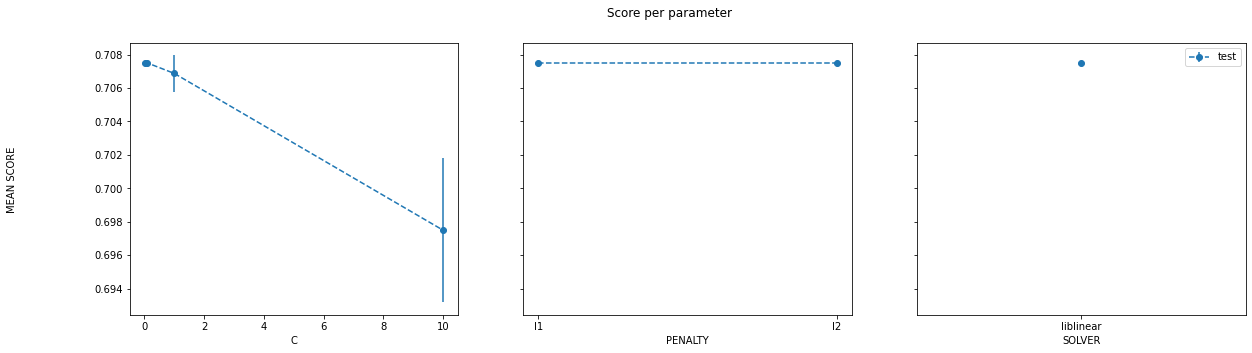

In [176]:
plot_search_results(resultados2)

### 7. Salvando o modelo
Agora podemos salvar o melhor modelo encontrado para aplicação posterior no score. Isso pode ser feito usando o pacote "pickle" que permite retirar esse modelo com os parâmetros obtidos no GridSearchCV.

In [188]:
import pickle
Pkl_Filename = "modelo_LR.pkl" 
model=resultados2.best_estimator_
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

### 8. Salvando os dados de treino e teste
por fim, salvamos os dados usados na estimativa (treino e teste) para reprodução futura.

In [189]:
xtreino.to_csv('xtreino.csv')
ytreino.to_csv('ytreino.csv')
xteste.to_csv('xteste.csv')
yteste.to_csv('yteste.csv')